This notebook compares two models from the notebooks: "TrainBaseModel" (MobileNetV2) and "Train-InceptionResNetV2" (InceptionResNetV2).

## Import Libraries & Load Models

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2, NASNetLarge, InceptionResNetV2
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as preprocess_mobile
from tensorflow.keras.applications.nasnet import preprocess_input as preprocess_nas
from tensorflow.keras.applications.inception_resnet_v2 import preprocess_input as preprocess_inc
from sklearn.metrics import roc_curve, auc
from data_loader import load_dir, create_dataset

2024-08-07 18:09:17.550949: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-07 18:09:17.568651: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 18:09:17.704927: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-08-07 18:09:17.851613: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-07 18:09:17.973967: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been 

In [2]:
model_mobile = tf.keras.models.load_model('Models/BaseModel.keras')
model_nas = tf.keras.models.load_model('Models/NASnetLarge.keras')
model_inc = tf.keras.models.load_model('Models/InceptionResNet.keras')

## Load & Prepare Data

In [3]:
# define
classes = ['buildings', 'street']
train_dir = 'first_100/seg_train/seg_train'
test_dir = 'first_100/seg_test/seg_test'
max_images = 50  # Number of images per class

image_size_mobile = (224, 224)
image_size_nas = (331, 331)
image_size_inc = (299, 299)

num_classes=2
batch_size=30

In [4]:
def resize(images, model, target_size):
    if model == "MobileNetV2":
        preprocess_func = preprocess_mobile
    elif model == "NASNetLarge":
        preprocess_func = preprocess_nas
    elif model == "InceptionResNetV2":
        preprocess_func = preprocess_inc
    else:
        raise ValueError("Unsupported model name")
    
    resized_images = np.array([tf.image.resize(img, target_size) for img in images])
    preprocessed_images = preprocess_func(resized_images)
    return preprocessed_images

In [5]:
# load
train_images, train_labels = load_dir(train_dir, classes, max_images,image_size_mobile)
test_images, test_labels = load_dir(test_dir, classes, max_images,image_size_mobile)

test_ds = create_dataset(test_images, test_labels, batch_size=batch_size)

In [6]:
# resize
test_images_mobile = resize(test_images, "MobileNetV2", image_size_mobile)
test_images_nas = resize(test_images, "NASNetLarge", image_size_nas)
test_images_inc = resize(test_images, "InceptionResNetV2", image_size_inc)

In [7]:
# verify shapes
print("MobileNetV2 test images shape:", test_images_mobile.shape)
print("NASNetLarge test images shape:", test_images_nas.shape)
print("InceptionResNetV2 test images shape:", test_images_inc.shape)

MobileNetV2 test images shape: (100, 224, 224, 3)
NASNetLarge test images shape: (100, 331, 331, 3)
InceptionResNetV2 test images shape: (100, 299, 299, 3)


In [8]:
# predict mobile
probs_mobile=model_mobile.predict(test_images_mobile)

4/4 ━━━━━━━━━━━━━━━━━━━━ 3s 616ms/step


In [ ]:
# predict nas
probs_nas=model_nas.predict(test_images_nas)

2024-08-07 18:08:47.268066: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 42071424 bytes after encountering the first element of size 42071424 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


Does not have enough memory to predict with NASNetLarge model. Will split model comparison notebooks -- NASNetLarge will be in notebook, "CompareModels-Nas"

In [9]:
# predict inc
probs_inc=model_inc.predict(test_images_inc)

4/4 ━━━━━━━━━━━━━━━━━━━━ 17s 3s/step


']
## Evaluate Models & Compare ROC

In [10]:
# ROC and AUCs
# fpr_nas, tpr_nas, _ = roc_curve(test_labels, probs_nas)
fpr_mobile, tpr_mobile, _ = roc_curve(test_labels, probs_mobile)
fpr_inc, tpr_inc, _ = roc_curve(test_labels, probs_inc)

# roc_auc_nas = auc(fpr_nas, tpr_nas)
roc_auc_mobile = auc(fpr_mobile, tpr_mobile)
roc_auc_inc = auc(fpr_inc, tpr_inc)

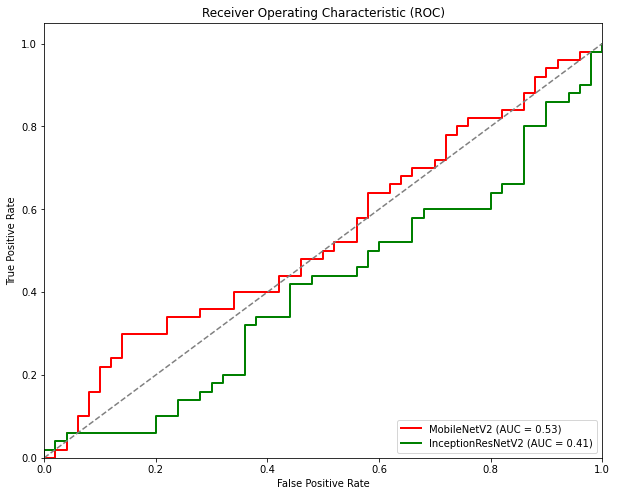

In [11]:
# plot
plt.figure(figsize=(10, 8))
# plt.plot(fpr_nas, tpr_nas, color='blue', lw=2, label=f'NASNetLarge (AUC = {roc_auc_nas:.2f})')
plt.plot(fpr_mobile, tpr_mobile, color='red', lw=2, label=f'MobileNetV2 (AUC = {roc_auc_mobile:.2f})')
plt.plot(fpr_inc, tpr_inc, color='green', lw=2, label=f'InceptionResNetV2 (AUC = {roc_auc_inc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc='lower right')
plt.show()

MobileNetV2 performs better than InceptionResNetV2, but it's still not an ideal model.